# Notes
- Recreating mg1655_expression.ipynb with xgboost and mrmr

In [1]:
from pathlib import Path
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pymodulon.io import load_json_model
from scipy.stats import f_oneway, gaussian_kde, mannwhitneyu, pearsonr, spearmanr
import seaborn as sns
import shap
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_predict, RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, plot_tree
from tqdm.notebook import tqdm

sys.path.append('../../bitome2')
sys.path.append('../')

from bitome.core import Bitome
from bitome.ml import *

sns.set_style('whitegrid')

shap.initjs()

In [2]:
# Bitome setup
K12_DATA_PATH = Path('../data/bitome2/mg1655')

# from GenBank annotation
origin = (3925743, 3925975)
# from 1. Duggin, I. G. & Bell, S. D. J. Mol. Biol. (2009). with the following terA/terC sequences:
# ter_a = 'AATTAGTATGTTGTAACTAAAGT'
# ter_c = 'ATATAGGATGTTGTAACTAATAT'
terminus = (1341745, 1609180)
cid_boundaries = [50000, 142779, 223485, 446815, 927474, 985894, 1080000, 1195008, 1301085, 1577657,
                 1799393, 1852621, 2102875, 2259719, 2380722, 2533498, 2726069, 2905711, 2996372, 3297098,
                 3423423, 3440040, 3652182, 3811250, 3941516, 4035239, 4166484, 4470986]

mg1655 = Bitome(
    Path(K12_DATA_PATH, 'NC_000913.3.gb'),
    name='MG1655',
    origin=origin, terminus=terminus,
    cid_boundaries=cid_boundaries,
    gene_table=Path(K12_DATA_PATH, 'gene_info_supp.csv'),
    tu_table=Path(K12_DATA_PATH, 'tu.csv'),
    operon_table=Path(K12_DATA_PATH, 'operon.csv'),
    tss_table=Path(K12_DATA_PATH, 'tss.csv'),
    tfbs_table=Path(K12_DATA_PATH, 'tfbs.csv'),
    terminator_table=Path(K12_DATA_PATH, 'terminator.csv'),
    attenuator_table=Path(K12_DATA_PATH, 'attenuator.csv'),
    rbs_table=Path(K12_DATA_PATH, 'rbs.csv'),
    riboswitch_table=Path(K12_DATA_PATH, 'riboswitch.csv')
)

precise2 = load_json_model('../data/precise2.json.gz')

# Genome Organization Features

## Prepare Feature Matrices

In [3]:
gene_table_copy = mg1655.gene_table.copy()
# for genome bins: https://www.sciencedirect.com/science/article/pii/S0092867417315076 Figure S2
go_table = mg1655.genome_organization_table(n_genome_bins=32, tm_range=(-13, -7), tm_use_box=False).dropna()
gene_table_ml = go_table.merge(gene_table_copy, left_index=True, right_index=True, how='left')
gene_table_ml = gene_table_ml.dropna(subset=['tpm'])
# we only want things with -10 and -35 box that have length 6 (for now) so we can one-hot
gene_table_ml = gene_table_ml[
    (gene_table_ml['box_10_seq'].apply(len) == 6) &
    (gene_table_ml['box_35_seq'].apply(len) == 6)
]
# we want to allow the 'reg_effect' column to be empty, have that as category
gene_table_ml['reg_effect'] = gene_table_ml['reg_effect'].fillna('none')
gene_table_ml

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction fun

,genome_loc_sin,genome_loc_cos,rep_region,origin_dist,tu_len,tu_gc,tu_order,tss_dist,tss_base,utr_len,...,pseudo,name,cog,essential,y-ome,tpm,tpm_ctrl,tpm_all,reg_effect,log_tpm
locus_tag,,,,,,,,,,,,,,,,,,,,,
b0002,0.00000,1.000000,leading,716014,4939.000000,0.532092,2.0,189.000000,A,42.000000,...,False,thrA,E,NaN,well-annotated,911.871207,1272.481486,663.451039,unknown,9.834268
b0003,0.00000,1.000000,leading,718478,4939.000000,0.532092,3.0,2653.000000,A,42.000000,...,False,thrB,E,NaN,well-annotated,771.705903,1010.478960,576.611751,unknown,9.593776
b0004,0.00000,1.000000,leading,719411,4939.000000,0.532092,4.0,3586.000000,A,42.000000,...,False,thrC,E,NaN,well-annotated,693.743865,1004.478234,530.762368,repressed,9.440337
b0014,0.00000,1.000000,leading,727840,3194.000000,0.522972,1.0,58.000000,A,58.000000,...,False,dnaK,O,NaN,well-annotated,729.254882,759.381289,952.836122,activated,9.512256
b0015,0.00000,1.000000,leading,729845,3194.000000,0.522972,2.0,2063.000000,A,58.000000,...,False,dnaJ,O,NaN,well-annotated,168.419194,190.013853,224.440656,activated,7.404454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b4397,-0.19509,0.980785,leading,709546,3487.000000,0.516499,1.0,161.000000,G,161.000000,...,False,creA,T,NaN,y-ome,82.674691,76.963569,85.927920,repressed,6.386719
b4398,-0.19509,0.980785,leading,710032,3487.000000,0.516499,2.0,647.000000,G,161.000000,...,False,creB,T,NaN,well-annotated,44.366562,60.604252,41.197456,repressed,5.503557
b4399,-0.19509,0.980785,leading,710721,3487.000000,0.516499,3.0,1336.000000,G,161.000000,...,False,creC,T,NaN,well-annotated,14.818771,16.075296,13.570748,repressed,3.983566


In [4]:
X = gene_table_ml.drop(columns=['left', 'right', 'strand', 'pseudo', 'name', 'cog', 'essential',
                               'y-ome', 'tpm_ctrl', 'tpm_all', 'log_tpm']).dropna()
y_go = X['tpm']
X = X.drop(columns=['tpm'])

def box_to_oh(box_seq, box):
    # not using pandas' get_dummies method ensures that we account for sequences that don't
    # have all 4 nucleotides, and also allows us to prepare a 1-dimensional one-hot vector
    one_hot_names = []
    one_hots = []
    for i, seq_base in enumerate(box_seq):
        for base in 'ACGT':
            one_hot_names.append(f'{box}_{i+1}_{base}')
            if base == seq_base:
                one_hots.append(1)
            else:
                one_hots.append(0)

    one_hot_sequence = pd.Series(one_hots, index=one_hot_names)
    return one_hot_sequence
    
box_10_oh_df = X['box_10_seq'].apply(lambda box_10_seq: box_to_oh(box_10_seq, '-10'))
box_35_oh_df = X['box_35_seq'].apply(lambda box_35_seq: box_to_oh(box_35_seq, '-35'))

X_all = pd.get_dummies(
    pd.concat([X, box_10_oh_df, box_35_oh_df], axis=1).drop(columns=['box_10_seq', 'box_35_seq']))
X_no_b10 = pd.get_dummies(
    pd.concat([X, box_35_oh_df], axis=1).drop(columns=['box_10_seq', 'box_35_seq']))
X_no_b35 = pd.get_dummies(
    pd.concat([X, box_10_oh_df], axis=1).drop(columns=['box_10_seq', 'box_35_seq']))
X_no_boxes = pd.get_dummies(X.drop(columns=['box_10_seq', 'box_35_seq', 'cid']))
X_no_spacer_gc = pd.get_dummies(X.drop(columns=['box_10_seq', 'box_35_seq', 'cid', 'spacer_gc']))

# add models missing -10, OR -35 information
Xy_to_try_go = {
    'all': (X_all, y_go),
    'no_b10': (X_no_b10, y_go),
    'no_b35': (X_no_b35, y_go),
    'no_boxes': (X_no_boxes, y_go), 
    'no_spacer_gc': (X_no_spacer_gc, y_go)
}

## Divide Data

In [5]:
Xy_train_go, Xy_lockbox_go = create_train_and_lockbox_sets(Xy_to_try_go, random_state=42)

## XGBoost

In [6]:
import xgboost as xgb

XGB: all__X_raw__y_raw


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


XGB: all__X_raw__y_log


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


XGB: all__X_standard__y_raw


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


XGB: all__X_standard__y_log


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


XGB: no_b10__X_raw__y_raw


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


XGB: no_b10__X_raw__y_log


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


XGB: no_b10__X_standard__y_raw


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


XGB: no_b10__X_standard__y_log


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


XGB: no_b35__X_raw__y_raw


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


XGB: no_b35__X_raw__y_log


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


XGB: no_b35__X_standard__y_raw


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


XGB: no_b35__X_standard__y_log


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


XGB: no_boxes__X_raw__y_raw


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


XGB: no_boxes__X_raw__y_log


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


XGB: no_boxes__X_standard__y_raw


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


XGB: no_boxes__X_standard__y_log


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


XGB: no_spacer_gc__X_raw__y_raw


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


XGB: no_spacer_gc__X_raw__y_log


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


XGB: no_spacer_gc__X_standard__y_raw


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


XGB: no_spacer_gc__X_standard__y_log


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(   model                               xy  train_score  val_score
 0    XGB                all__X_raw__y_raw     0.999035   0.792296
 1    XGB                all__X_raw__y_raw     0.999141   0.333672
 2    XGB                all__X_raw__y_raw     0.999277  -1.978589
 3    XGB                all__X_raw__y_raw     0.999309  -0.049554
 4    XGB                all__X_raw__y_raw     0.999503   0.242637
 ..   ...                              ...          ...        ...
 3    XGB  no_spacer_gc__X_standard__y_log     0.997517   0.598208
 4    XGB  no_spacer_gc__X_standard__y_log     0.997759   0.535581
 5    XGB  no_spacer_gc__X_standard__y_log     0.997662   0.707013
 6    XGB  no_spacer_gc__X_standard__y_log     0.997534   0.603653
 7    XGB  no_spacer_gc__X_standard__y_log     0.997311   0.607054
 
 [160 rows x 4 columns],
 <AxesSubplot:ylabel='Training r2'>,
 <AxesSubplot:ylabel='Validation r2'>)

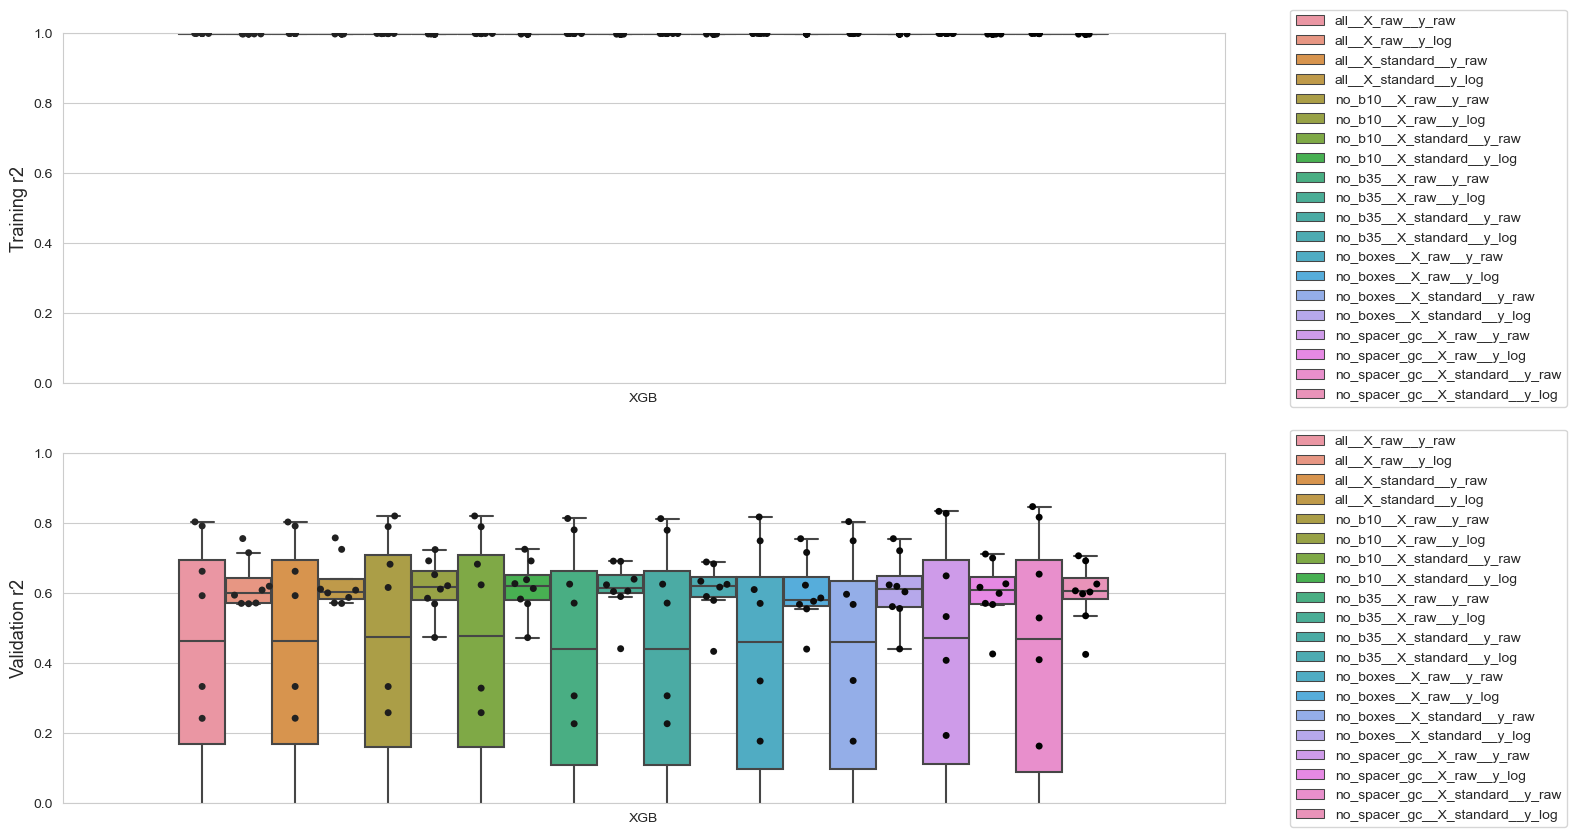

In [7]:
models_to_try = {
    #'ElasticNet': ElasticNet(),
    #'SVR': SVR(),
    #'DTree': DecisionTreeRegressor(max_depth=5),
    #'RF': RandomForestRegressor(n_jobs=4)
    #'NN': MLPRegressor()
    'XGB': xgb.XGBRegressor()
}

profile_xy_and_models(Xy_train_go, models_to_try, scoring='r2', n_cv=8,
                      x_preprocessing=['standard'], y_preprocessing=['log'],
                      verbose=True)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


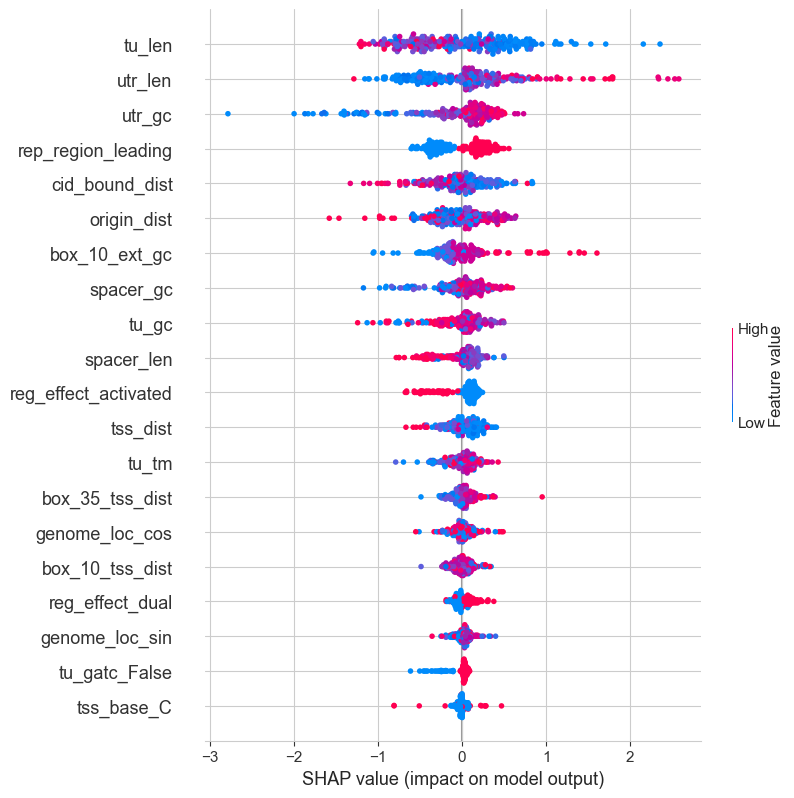

In [8]:
x_go_fi_raw = Xy_train_go['no_boxes'][0]
x_go_fi = pd.DataFrame(
    StandardScaler().fit_transform(x_go_fi_raw),
    columns=x_go_fi_raw.columns,
    index=x_go_fi_raw.index
)
y_go_fi = np.log2(Xy_train_go['no_boxes'][1].values + 1)

feature_importance(x_go_fi, y_go_fi, models_to_try['XGB'])

## minimal Redundancy Maximum Relevancy

In [9]:
import mrmr

In [10]:
results = {}
for key in Xy_to_try_go:
    results[key] = mrmr.mrmr_regression(Xy_to_try_go[key][0],Xy_to_try_go[key][1],20)

100%|██████████| 20/20 [00:00<00:00, 120.56it/s]


In [11]:
results['all']

['cid_cid_21',
 '-10_6_T',
 'tss_base_C',
 'cid_cid_10',
 'rep_region_lagging',
 'box_10_ext_gc',
 '-10_3_C',
 'tu_gc',
 '-35_3_G',
 '-10_4_A',
 'utr_len',
 '-35_1_T',
 'cid_bound_dist',
 'reg_effect_dual',
 'rep_region_leading',
 'box_35_tss_dist',
 '-35_5_G',
 'spacer_gc',
 'reg_effect_repressed',
 'tss_base_T']